In [1]:
#!pip install pillow

#### Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#### Insight: determine the batch size number to use 

In [3]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132)

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790)

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


#### Preview images (Normal)

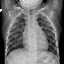

In [15]:
array_to_img(train_images[0])

In [16]:
print(train_labels[0])

[1. 0.]


#### Preview Images (Pneumonia)

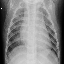

In [6]:
array_to_img(train_images[90])


In [7]:
print(train_labels[90])

[0. 1.]


In [8]:
print('train images shape: ',np.shape(train_images))
print('train labels shape: ',np.shape(train_labels))
print('test images shape: ',np.shape(test_images))
print('test labels shape: ',np.shape(test_labels))

train images shape:  (790, 64, 64, 3)
train labels shape:  (790, 2)
test images shape:  (132, 64, 64, 3)
test labels shape:  (132, 2)


#### Reshape and transpose images

In [9]:
#train set
train_img_unrow = train_images.reshape(790, -1).T
train_img_unrow.shape

(12288, 790)

In [11]:
#test set
test_img_unrow = test_images.reshape(132, -1).T
test_img_unrow.shape

(12288, 132)

#### Labels for images

In [14]:
train_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [13]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Transpose and resize train and test sets

In [17]:
#training set
train_labels_final = train_labels.T[[1]]

In [18]:
np.shape(train_labels_final)

(1, 790)

In [19]:
#test set
test_labels_final = test_labels.T[[1]]

In [20]:
np.shape(test_labels_final) 

(1, 132)

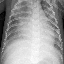

In [21]:
array_to_img(train_images[240])

In [22]:
train_labels_final[:,240]

array([1.], dtype=float32)

In [23]:
#scaling the data
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

#### create convolution filter, padding (and maybe striding?) and pooling layer (if there are too many features)